# States for MDP 

States from paper

http://www.ijmlc.org/vol5/515-C003.pdf

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm
import states

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '13003'

In [3]:
df, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', length=data_length)
df.drop(columns=['bid', 'ask'], inplace=True)

In [4]:
print(len(df))
df.head()

8000


,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2000,2013-09-11 13:28:00,419.8,420.0,419.90,3953.0,4528.0,0.0,0.067799
2001,2013-09-11 13:29:00,419.7,420.0,419.85,3384.0,4318.0,1.0,0.121267
2002,2013-09-11 13:32:00,419.8,420.0,419.90,4000.0,2244.0,1.0,-0.281230
2003,2013-09-11 13:35:00,419.9,420.0,419.95,4600.0,1978.0,0.0,-0.398601
2004,2013-09-11 13:37:00,419.8,420.0,419.90,2941.0,6126.0,1.0,0.351274


## Introduce states

    state will be bid_price, ask_price, spread, sum_sell_ask, sum_buy_bid, mid_price
    queue imbalance
    TODO: spread does not seem to have any sense!

In [5]:
df = states.add_state(df)
df.head()

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,spread,state_ask,state_bid,state_sum_ask,state_sum_bid,state_spread,state_imbalance,state_mid
2000,2013-09-11 13:28:00,419.8,420.0,419.90,3953.0,4528.0,0.0,0.067799,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,2013-09-11 13:29:00,419.7,420.0,419.85,3384.0,4318.0,1.0,0.121267,0.3,0.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
2002,2013-09-11 13:32:00,419.8,420.0,419.90,4000.0,2244.0,1.0,-0.281230,0.2,0.0,1.0,1.0,-1.0,-1.0,-1.0,1.0
2003,2013-09-11 13:35:00,419.9,420.0,419.95,4600.0,1978.0,0.0,-0.398601,0.1,0.0,1.0,1.0,-1.0,-1.0,-1.0,1.0
2004,2013-09-11 13:37:00,419.8,420.0,419.90,2941.0,6126.0,1.0,0.351274,0.2,0.0,-1.0,-1.0,1.0,1.0,1.0,-1.0


## Clustering states attempt

In [6]:
df.dropna(inplace=True)
state_labels = [c for c in df.columns if 'state' in c]
dbscan = cluster.DBSCAN()
groups = dbscan.fit_predict(df[state_labels])
df['groups'] = groups

In [7]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets


@interact(num=(-1, len(np.unique(dbscan.labels_)) - 1))
def _plot_lob(num):
    py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

    data = []
    for i in state_labels:
        data.append(go.Scatter(
            x=df.index, # assign x as the dataframe column 'x'
            y=df[df['groups'] == num][i], name=i, opacity=0.25))
    title='df {}'.format(len(df[df['groups'] == num]))
    layout = go.Layout(
            title = title,
            showlegend = True,
            legend = dict(orientation="h")
        )

    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure, filename='pandas/basic-line-plot', config=py_config)

Widget Javascript not detected.  It may not be installed or enabled properly.


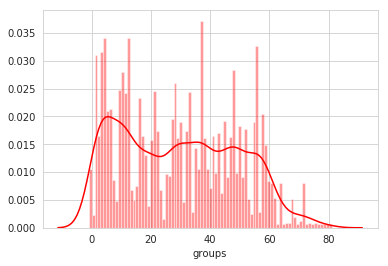

In [8]:
sns.distplot(df['groups'], bins=len(df['groups'].unique()), color='r')

## Let's hash the states



In [9]:
hashes = []
for i, row in df.iterrows():
    hashes.append(states.get_state_number(df, i))
df['hash'] = hashes
df[['hash']].head(5)

,hash
2001,181
2002,547
2003,547
2004,1639
2005,547


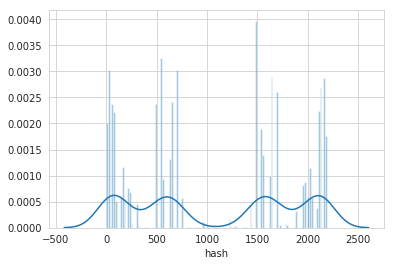

In [10]:
sns.distplot(df['hash'], bins=len(df['hash'].unique()))

In [11]:
df['hash'].unique()

array([ 181,  547, 1639, 1476,  710, 1697,  489,  162, 2105,   61, 2125,
       1700, 1638, 2087, 2005,  180,  629, 1537, 2183,  163,   62,  648,
       1619, 1436,    6, 1962,  242,  486,  548,    0, 2124, 2023,    3,
       1557, 1218,   80,  143, 1479, 2106,  224, 2024,  567, 2043, 2186,
       1944,   18,   99, 1538, 2165,  750, 2107,   81,  649, 2006,  221,
        707,   21,  239, 2168,   79, 2025, 1950, 1947, 1781, 1965,   78,
        304,   24, 1482, 1378,  492,  909, 1882,  808,  809,  968,   33,
         60,  161, 1780, 2162, 1042,  464, 2108,  910, 1940, 1439,  747,
       1800, 1722, 1640, 1358,  324, 2153, 1377, 1276,  243, 1719,  218,
        467, 1296, 2135,  386, 1694, 1536,   51,  246,  406, 1881,  650,
       1977, 1862, 2126, 1277,  828, 2180,  519,  971,  984,  677,  890,
        704, 1248, 2004,  405, 2022])

In [12]:
def get_transitions(df):
    transitions = np.zeros((max(df['hash'])+1, max(df['hash'] + 1)))
    previous_row = None
    for i, row in df.iterrows():
        if not np.any(previous_row):
            previous_row = row
            continue
        transitions[row['hash']][previous_row['hash']] += 1
        previous_row = row

    for j in range(len(transitions)):
        s = np.sum(transitions[j])
        if s == 0:
            continue
        for i in range(len(transitions[j])):
            transitions[j][i] = transitions[j][i]/s
    return transitions

transitions = get_transitions(df)

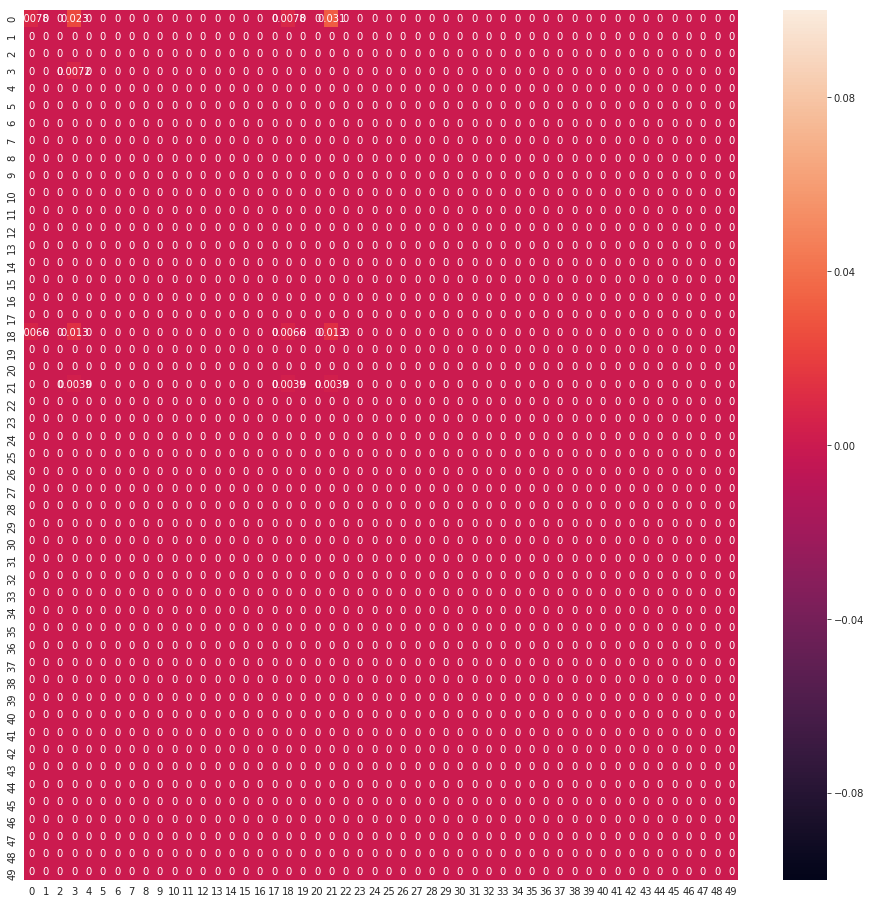

In [15]:
temp = np.zeros((50, 50))
for i in range(len(temp)):
    for j in range(len(temp[i])):
        temp[i][j] = transitions[i][j]
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(temp, annot=True, ax=ax, robust=True)

In [16]:
for j in range(len(transitions)):
    if np.sum(transitions[j]) < 0.999999 and j in df['hash'].values:
        print(j, np.sum(transitions[j]))

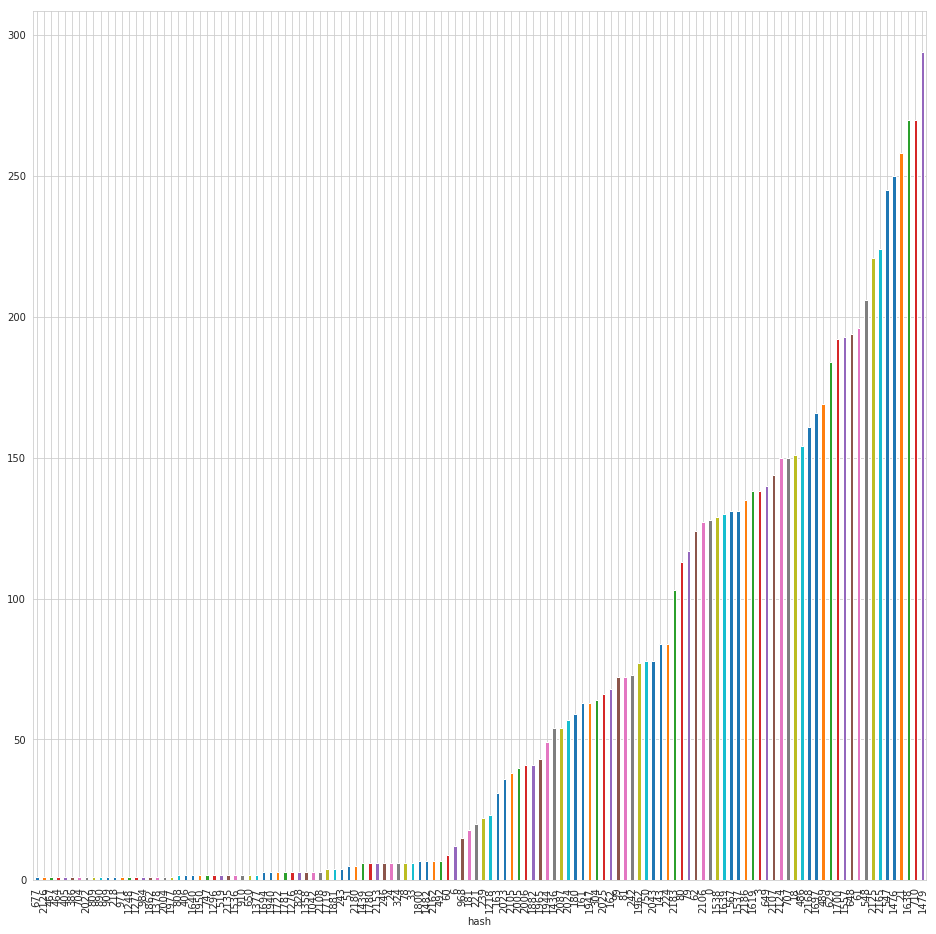

In [17]:
df.groupby(by='hash')['hash'].count().sort_values().plot(kind='bar', figsize=(16, 16))

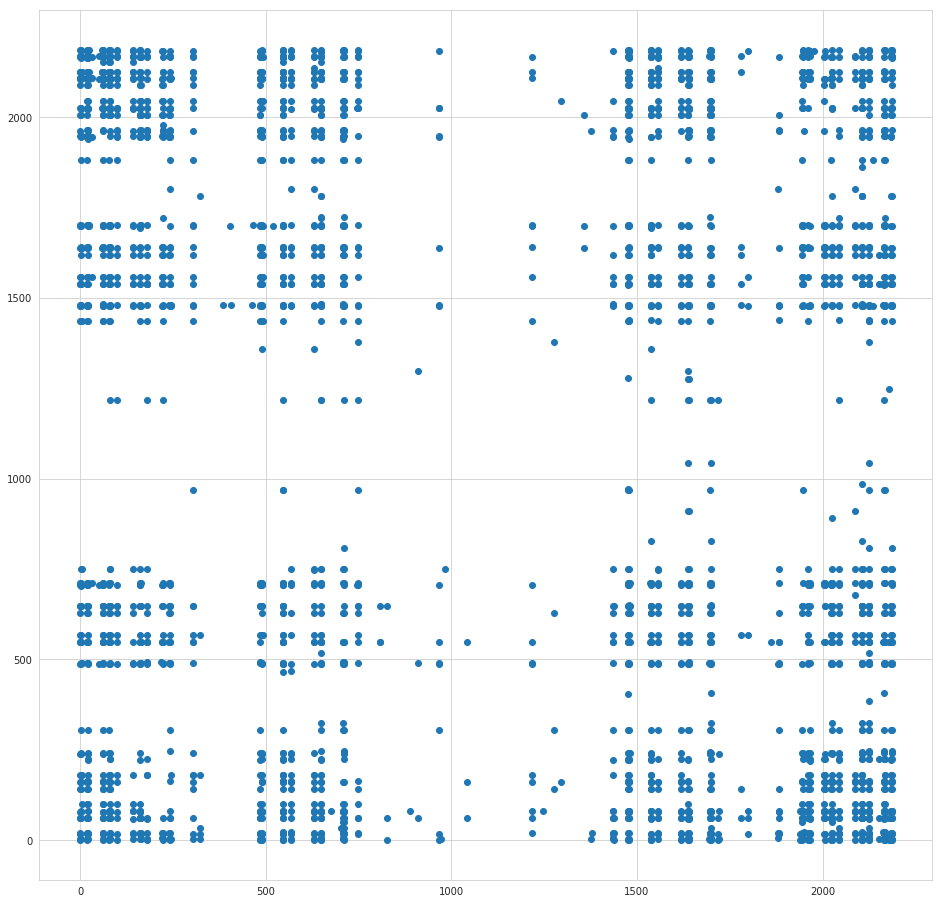

In [18]:
x = []
y = []
for i in range(len(transitions)):
    for j in range(len(transitions)):
        if transitions[i][j] > 0:
            x.append(i)
            y.append(j)
            
plt.figure(figsize=(16,16))
plt.scatter(x, y)

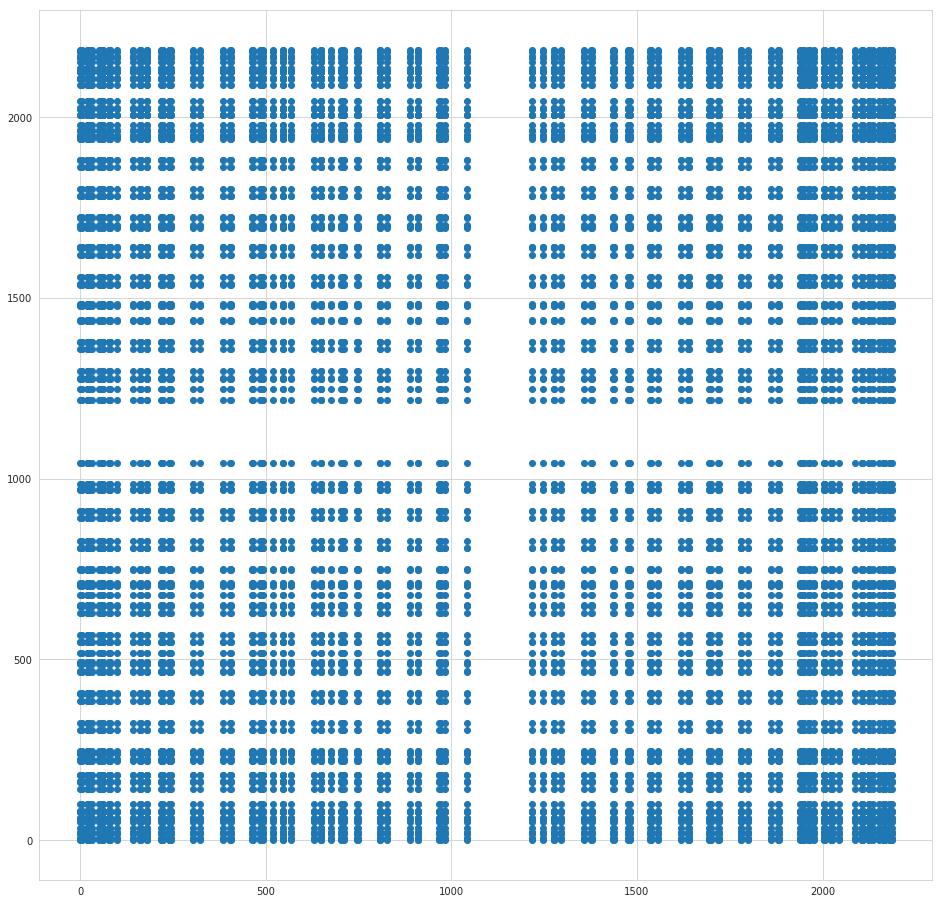

In [19]:
def plot_matrix(m2):
    x = []
    y = []
    for i in range(len(m2.A)):
        for j in range(len(m2.A)):
            if m2.A[i][j] > 0:
                x.append(i)
                y.append(j)

    plt.figure(figsize=(16,16))
    plt.scatter(x, y)

m = np.matrix(transitions)
m2 = np.linalg.matrix_power(m, 100)
plot_matrix(m2)

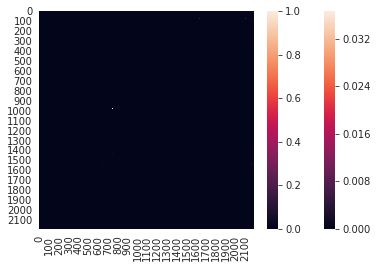

In [20]:
sns.heatmap(m2)
sns.heatmap(m)

## Accessibility of states

P - transition matrix

State j is said to be accessible from state i if $P_{ij}^n > 0$ for some $n >= 0$.
Two states i and j that are accessible to each other are said to communicate.

In [21]:
def if_states_communicating(transitions, state1, state2):
    return transitions[state1][state2] != 0.00000 and transitions[state2][state1] != 0.000000

if_states_communicating(transitions, 181, 547)

True

In [22]:
def get_state_groups(transitions):
    groups = [[i] for i in list(range(len(transitions)))]
    for i in range(len(transitions)):
        for j in range(len(transitions)):
            if if_states_communicating(transitions, i, j):
                groups[i].append(j)
    return groups
        
groups = get_state_groups(transitions)

(2110, 77)

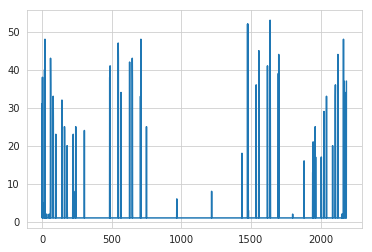

In [23]:
def get_group_lengths(groups, plot=False):
    groups_lengths = [len(g) for g in groups]
    if plot:
        plt.plot(groups_lengths)
    empty_groups = 0
    for i in range(len(groups_lengths)):
        if groups_lengths[i] <= 1:
            empty_groups += 1
    return empty_groups, len(groups_lengths) - empty_groups

get_group_lengths(groups, plot=True)

In [24]:
def plot_heatmap(transitions, plot_name='transitions.png'):
    hashes = df['hash'].unique()
    transition_states_only = []

    for i in range(len(hashes)):
        for j in range(len(hashes)):
            transition_states_only.append({'i': i, 'j': j, 'val': transitions[hashes[i]][hashes[j]]})
    
    fig, ax = plt.subplots(figsize=(64, 64))
    df_trans = pd.DataFrame(transition_states_only)
    df_trans = df_trans.pivot('i', 'j', 'val')
    sns.heatmap(df_trans, annot=True, ax=ax, robust=True)
    plt.savefig(plot_name)
    return df_trans

In [25]:
temp = np.matmul(transitions, transitions)
for i in range(2, 10):
    groups2 = get_state_groups(temp)
    g = get_group_lengths(groups2)
    temp = np.matmul(temp, transitions)
df_trans = plot_heatmap(temp, plot_name='plots/transitions_{}_{}.png'.format(stock, i))
plt.title('{} {}'.format(i, g))
get_group_lengths(groups2, plot=True)

(2061, 126)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [27]:
n = 20
d_trans =  plot_heatmap(np.linalg.matrix_power(transitions, n), 
                        plot_name='transitions_{}_{}.png'.format(stock, n))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [65]:
def if_list_equal(l1, l2):
    for i in l1:
        if i not in l2:
            return False
    for i in l2:
        if i not in l1:
            return False
    return True

unique_groups = []

for i in range(len(groups2)):
    unique = True
    for j in range(i+1, len(groups2)):
        if if_list_equal(groups2[i], groups2[j]):
            False
    if unique:
        unique_groups.append(i)

In [67]:
get_group_lengths(groups2)

(2061, 126)